In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## Process PanCanAtlas file

In [2]:
rna=pd.read_csv("/cellar/users/mpagadal/Data/resources/immune-landscape/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv",delimiter="\t")
rna=rna.set_index("gene_id")
rna=rna.T
rna.columns=[x.split("|")[0] for x in rna.columns]

In [3]:
print(rna.shape)

(11069, 20531)


In [4]:
rna["code"]=rna.index.str.split("-").str[3]
rna["barcode"]=rna.index.str[0:12]

In [5]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
rna["cancer"]=rna["barcode"].map(mp)

In [6]:
# rna_skcm=rna[(rna["cancer"]=="SKCM")&(rna["code"].isin(["06A","06B","01A"]))]
# rna_other=rna[(rna["cancer"]!="SKCM")&(rna["code"].str.contains("01"))]
# rna_tumor=rna_skcm.append(rna_other)

In [7]:
rna_tumor=rna[rna["code"].str.contains("01")]

In [8]:
rna_tumor["code"].value_counts()

01A    9572
01B     129
01C       4
01R       1
Name: code, dtype: int64

In [9]:
#convert index to short barcodes
del rna_tumor["code"]
del rna_tumor["cancer"]
rna_tumor.index=rna_tumor["barcode"]
del rna_tumor["barcode"]

In [10]:
print(rna_tumor.shape)

(9706, 20531)


In [11]:
cols=[x for x in rna_tumor.columns if x!="?"]
rna_tumor=rna_tumor[cols]

In [12]:
#take mean for individuals with multiple samples
rna=rna_tumor
rna=rna.groupby(rna.index).mean()

In [13]:
rna = rna.apply(pd.to_numeric,errors="coerce")

In [14]:
rna=rna.fillna(0.0)

In [15]:
rna.to_csv("/cellar/users/mpagadal/Data/resources/tcga/pancanatlas-rna-clean.tsv",sep="\t")

### process file for cibersortx input

In [71]:
ciber=rna.T

In [72]:
ciber=ciber.reset_index()

In [73]:
ciber=ciber.rename(columns={"index":"Gene"})

In [74]:
ciber=ciber.set_index("Gene")

In [75]:
ciber.to_csv("/cellar/users/mpagadal/Data/cibersort/cibersortx-inputs/pancanatlas_mixture.tsv",sep="\t")

## Retrieve immune microenvironment phenotypes

In [17]:
genes=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/downloaded_phenos/all_rna_lst.txt",delimiter="\t",header=None)[0].tolist()
#genes=pd.read_csv("/cellar/users/mpagadal/Data/gtex/gtex_rand_genes.txt")


In [20]:
#map to alternative ids
mp_ids={"CMC2":"C16orf61",
    "ADGRE5":"CD97",
    "SPRYD7":"C13orf1",
    "JCHAIN":"IGJ",
    "CTSL":"CTSL1",
    "CTSV":"CTSL2",
     "TEX30":"C13orf27",
     "CENPU":"MLF1IP",
     "CMSS1":"C3orf26",
     "FAM216A":"C12orf24",
     "HACD2":"PTPLB",
    "MARCHF1":"MARCH1"}

final_genes=[]
for x in genes:
    if x in [x for x in mp_ids.keys()]:
        final_genes.append(mp_ids[x])
    else:
        final_genes.append(x)

### update phenotype dictionary

In [21]:
with open('pheno_dictionary.json', 'r') as f:
    pheno_dict = json.load(f)

In [22]:
for x in mp_ids.keys():
    pheno_dict[mp_ids[x]]=pheno_dict[x]

In [23]:
print("These genes are missing")
len([x for x in set(final_genes) if x not in rna.columns])

These genes are missing


5

In [24]:
final_genes=[x for x in set(final_genes) if x in rna.columns]

In [25]:
#filter for immune genes
rna_immune=rna[final_genes]

In [26]:
rna_immune_final=rna_immune.reset_index().rename(columns={"barcode":"FID"}).set_index("FID")

### Get only phenotypes with less than 10% zero values

In [27]:
def filter_zeros(df,threshold):
    '''
    inputs:
    df: dataframe of rna values
    threshold: % of zero values by which to exclude phenotypes
    
    output:
    dataframe with rna values < threshold of zero values
    '''
    
    keep=[]
    remove=[]
    
    for x in df.columns:
        if len(df[df[x]==0])>threshold*len(df):
            remove.append(x)
        else:
            keep.append(x)
    
    print("{} phenotypes with > {} zeroes were removed".format(len(remove),threshold))
    return(df[keep])
        

In [28]:
rna_immune_final=filter_zeros(rna_immune_final,0.1)

36 phenotypes with > 0.1 zeroes were removed


## Get CIBERSORTx values

In [29]:
ciber=pd.read_csv("/cellar/users/mpagadal/Data/cibersort/pancanatlas_cibersortx_compiled_allsig.tsv",delimiter="\t")
ciber.columns=[x.replace(" ",".") for x in ciber.columns]
ciber=ciber.rename(columns={"Mixture":"FID"})
ciber.head()

,FID,dice.CD4_STIM,dice.CD4_NAIVE,dice.B_CELL_NAIVE,dice.TH2,dice.THSTAR,dice.NK,dice.MONOCYTES,dice.CD8_STIM,dice.CD8_NAIVE,...,melanoma.NK.cells,melanoma.Macrophages,melanoma.T.cells.CD4,melanoma.B.cells,NSCLC.Fig2ab.T.cells.CD8,NSCLC.Fig2ab.Monocytes,NSCLC.Fig2ab.T.cells.CD4,NSCLC.Fig2ab.NKT.cells,NSCLC.Fig2ab.B.cells,NSCLC.Fig2ab.NK.cells
0,TCGA-02-0047,0.0,0.0,0.000000,0.087753,0.00000,0.000000,0.000000,0.036063,0.000000,...,0.0,0.247082,0.000000,0.067366,0.000000,0.012288,0.0,0.097632,0.890080,0.0
1,TCGA-02-0055,0.0,0.0,0.000000,0.380587,0.01712,0.000000,0.008117,0.188048,0.000000,...,0.0,0.181053,0.000000,0.000000,0.079581,0.048478,0.0,0.000000,0.871942,0.0
2,TCGA-02-2483,0.0,0.0,0.000397,0.141497,0.00000,0.001787,0.000000,0.058280,0.000000,...,0.0,0.270816,0.000000,0.000000,0.052034,0.059809,0.0,0.000000,0.888157,0.0
3,TCGA-02-2485,0.0,0.0,0.019888,0.082664,0.00000,0.000000,0.000000,0.031935,0.040701,...,0.0,0.165778,0.000000,0.000000,0.117404,0.037993,0.0,0.000000,0.844603,0.0
4,TCGA-02-2486,0.0,0.0,0.000000,0.081778,0.00000,0.000000,0.015551,0.059936,0.005295,...,0.0,0.350058,0.052021,0.000000,0.054945,0.045343,0.0,0.000000,0.899712,0.0


In [30]:
ciber=filter_zeros(ciber,0.1)

50 phenotypes with > 0.1 zeroes were removed


## Get Immune Landscape Values

In [31]:
landscape=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t")
landscape=landscape.replace(-9, np.nan)
del landscape["IID"]
landscape.head()

,FID,Proliferation,Wound.Healing,Macrophage.Regulation,Lymphocyte.Infiltration.Signature.Score,IFN.gamma.Response,TGF.beta.Response
0,TCGA-01-0639,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-02-0007,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-02-0011,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0023,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0025,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
total=pd.merge(rna_immune_final,landscape,on=["FID"],how="outer")
total=pd.merge(total, ciber,on=["FID"],how="outer")

In [33]:
print(total.shape)
total.head()

(11185, 742)


,FID,RAB34,ZYX,CCL13,UMPS,MCM3,HLA-G,PSMB5,MTA1,HMGN2,...,dice.M2,dice.TH1,LM22.T.cells.CD4.memory.resting,LM22.T.cells.follicular.helper,LM22.Macrophages.M2,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages,NSCLC.Fig2ab.B.cells
0,TCGA-02-0047,424.106,3867.97,0.6146,440.087,1215.160,6.1280,1593.78,986.509,4714.96,...,0.394753,0.131543,0.220653,0.022100,0.300378,0.513596,0.324371,0.335930,0.247082,0.890080
1,TCGA-02-0055,1987.390,11481.40,62.2285,465.873,1490.120,136.7740,2654.52,612.754,6988.65,...,0.336683,0.055699,0.254034,0.104339,0.228286,0.679564,0.031077,0.799137,0.181053,0.871942
2,TCGA-02-2483,293.404,5066.81,0.0000,737.520,2713.670,13.7583,3078.84,1652.770,16686.40,...,0.400904,0.000000,0.252846,0.021372,0.333468,0.371056,0.401335,0.296509,0.270816,0.888157
3,TCGA-02-2485,1070.950,5090.95,0.0000,533.333,2458.100,2.3810,2555.71,1721.430,9975.24,...,0.246473,0.174376,0.039196,0.072461,0.383618,0.374810,0.582110,0.262455,0.165778,0.844603
4,TCGA-02-2486,2387.800,7800.00,1.8293,557.927,868.293,11.1829,2007.93,825.610,5520.73,...,0.400024,0.163527,0.120351,0.024661,0.550307,0.519750,0.134848,0.273583,0.350058,0.899712


In [34]:
total=total.reset_index()

### filter for genotyped individuals

In [35]:
#get genotyped patients
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",header=None,sep=" ")[0].tolist()

In [36]:
tcga_df=total[total.FID.isin(fam)]

In [37]:
print(tcga_df.shape)
tcga_df.head()

(8189, 743)


,index,FID,RAB34,ZYX,CCL13,UMPS,MCM3,HLA-G,PSMB5,MTA1,...,dice.M2,dice.TH1,LM22.T.cells.CD4.memory.resting,LM22.T.cells.follicular.helper,LM22.Macrophages.M2,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages,NSCLC.Fig2ab.B.cells
0,0,TCGA-02-0047,424.106000,3867.970000,0.614600,440.087000,1215.160000,6.12800,1593.780000,986.509000,...,0.394753,0.131543,0.220653,0.022100,0.300378,0.513596,0.324371,0.335930,0.247082,0.890080
1,1,TCGA-02-0055,1987.390000,11481.400000,62.228500,465.873000,1490.120000,136.77400,2654.520000,612.754000,...,0.336683,0.055699,0.254034,0.104339,0.228286,0.679564,0.031077,0.799137,0.181053,0.871942
4,4,TCGA-02-2486,2387.800000,7800.000000,1.829300,557.927000,868.293000,11.18290,2007.930000,825.610000,...,0.400024,0.163527,0.120351,0.024661,0.550307,0.519750,0.134848,0.273583,0.350058,0.899712
6,6,TCGA-04-1357,983.982428,3284.754545,10.636229,802.633551,1380.589227,132.89256,3416.254870,1639.085679,...,0.143543,0.393192,0.186436,0.082638,0.152219,0.428190,0.060116,0.154576,0.397849,0.900281
7,7,TCGA-04-1362,2007.040302,3747.937644,0.823273,1222.854511,3955.755455,26.53889,2234.594093,1312.474358,...,0.199769,0.195251,0.235363,0.071900,0.272240,0.271329,0.272688,0.348677,0.211550,0.855725


## Zscore by cancer

In [38]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
#total['cancer'] = total["FID"].map(mp)
tcga_df["cancer"]=tcga_df["FID"].map(mp)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [39]:
for x in tcga_df["cancer"].unique():
    try:
        tumor=tcga_df[tcga_df["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        print(x)
    
    

### To get inverse rank normalized phenos

Rscript run-rank-norm.R rna_phenos

In [40]:
cancers=tcga_df["cancer"].unique().tolist()

In [41]:
compiled=pd.DataFrame()
for x in cancers:
    df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/pheno_"+x+".rank.csv",delimiter="\t")
    df["cancer"]=x
    compiled=compiled.append(df)

### Confirm phenos are z-scored by cancer

Text(0.5, 1.0, 'FGR')

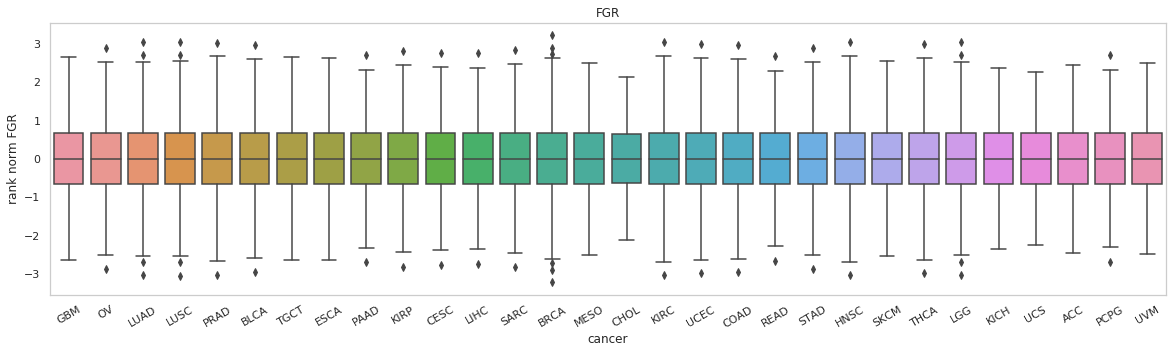

In [42]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

## Format for plink

In [43]:
del compiled["cancer"]

In [44]:
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [45]:
compiled.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/pheno_all_zcancer",index=None,sep="\t")

In [46]:
print(compiled.shape)
compiled.head()

(8189, 743)


,FID,IID,ID2,ERAP2,VAMP8,FAM89B,RASSF4,MYBL2,MYCBP,LYN,...,dice.M2,dice.TH1,LM22.T.cells.CD4.memory.resting,LM22.T.cells.follicular.helper,LM22.Macrophages.M2,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages,NSCLC.Fig2ab.B.cells
1,TCGA-02-0047,TCGA-02-0047,-0.832798,0.208664,-0.381976,-0.124617,1.135422,-0.041444,-0.208664,0.472789,...,0.892918,0.720732,0.449747,-0.426942,-0.124617,0.315916,-0.103766,0.404357,0.496085,0.592197
2,TCGA-02-0055,TCGA-02-0055,-1.415149,-0.924220,0.989714,0.832798,-1.310335,-0.862469,1.135422,0.803843,...,0.315916,-0.519653,0.803843,1.609816,-0.775547,1.896823,-2.641070,2.244607,-0.062188,0.166494
3,TCGA-02-2486,TCGA-02-2486,-0.592197,0.989714,1.609816,0.617068,-0.208664,-2.641070,0.862469,1.415149,...,0.989714,1.218220,-0.803843,-0.294213,1.310335,0.381976,-1.473947,0.020717,1.415149,0.694126
4,TCGA-06-0129,TCGA-06-0129,-0.803843,0.694126,-0.272648,-0.519653,2.641070,1.096804,-0.747859,0.989714,...,-0.208664,-1.024106,-0.567686,0.519653,1.538334,-2.641070,-0.404357,-2.244607,2.641070,0.187537
5,TCGA-06-0130,TCGA-06-0130,-0.956454,2.040281,1.310335,1.896823,0.642327,-0.062188,1.784268,1.784268,...,2.040281,-0.082959,-0.617068,-0.103766,1.096804,0.000000,-1.896823,1.609816,1.609816,2.641070


In [47]:
compiled[compiled["FID"].duplicated()]

,FID,IID,ID2,ERAP2,VAMP8,FAM89B,RASSF4,MYBL2,MYCBP,LYN,...,dice.M2,dice.TH1,LM22.T.cells.CD4.memory.resting,LM22.T.cells.follicular.helper,LM22.Macrophages.M2,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages,NSCLC.Fig2ab.B.cells


## Confirm phenotypes are normally distributed

In [104]:
pheno=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/pheno_all_zcancer",delimiter="\t")
pheno.head()

,FID,IID,ID2,ERAP2,VAMP8,FAM89B,RASSF4,MYBL2,MYCBP,LYN,...,dice.M2,dice.TH1,LM22.T.cells.CD4.memory.resting,LM22.T.cells.follicular.helper,LM22.Macrophages.M2,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages,NSCLC.Fig2ab.B.cells
0,TCGA-02-0047,TCGA-02-0047,-0.832798,0.208664,-0.381976,-0.124617,1.135422,-0.041444,-0.208664,0.472789,...,0.892918,0.720732,0.449747,-0.426942,-0.124617,0.315916,-0.103766,0.404357,0.496085,0.592197
1,TCGA-02-0055,TCGA-02-0055,-1.415149,-0.924220,0.989714,0.832798,-1.310335,-0.862469,1.135422,0.803843,...,0.315916,-0.519653,0.803843,1.609816,-0.775547,1.896823,-2.641070,2.244607,-0.062188,0.166494
2,TCGA-02-2486,TCGA-02-2486,-0.592197,0.989714,1.609816,0.617068,-0.208664,-2.641070,0.862469,1.415149,...,0.989714,1.218220,-0.803843,-0.294213,1.310335,0.381976,-1.473947,0.020717,1.415149,0.694126
3,TCGA-06-0129,TCGA-06-0129,-0.803843,0.694126,-0.272648,-0.519653,2.641070,1.096804,-0.747859,0.989714,...,-0.208664,-1.024106,-0.567686,0.519653,1.538334,-2.641070,-0.404357,-2.244607,2.641070,0.187537
4,TCGA-06-0130,TCGA-06-0130,-0.956454,2.040281,1.310335,1.896823,0.642327,-0.062188,1.784268,1.784268,...,2.040281,-0.082959,-0.617068,-0.103766,1.096804,0.000000,-1.896823,1.609816,1.609816,2.641070


(array([ 962.,    0.,    0.,    0.,   13.,  332., 2030., 3280., 1407.,
         165.]),
 array([-9.        , -7.777602  , -6.55520401, -5.33280601, -4.11040802,
        -2.88801002, -1.66561203, -0.44321403,  0.77918396,  2.00158196,
         3.22397995]),
 <a list of 10 Patch objects>)

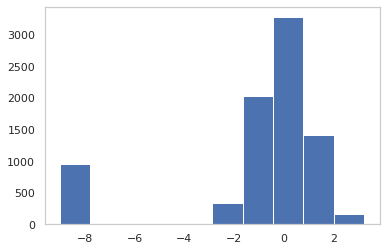

In [105]:
plt.hist(pheno["KIF3B"])

## Get Pearson correlation

In [106]:
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",header=None,sep=" ")

In [107]:
del pheno["IID"]

In [108]:
pheno=pheno.replace(-9, np.nan)

In [109]:
pheno_corr=pheno.corr(method="pearson")

In [110]:
pheno_corr.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/immune-phenotype-pearson/pancan.immune.phenotypes.pearson.csv")